In [ ]:
!pip3 install wikidataintegrator

In [ ]:
import pandas as pd
from wikidataintegrator import wdi_core

academy_awards = { "best actress"    : "Q103618",
                   "best actor"      : "Q103916",
                   "support actress" : "Q106301",
                   "support actor"   : "Q106291",
                   "directing"       : "Q103360",
                   "orig screenplay" : "Q41417"}

query = """
SELECT DISTINCT ?celebrity ?celebrityLabel ?awardtime ?placeOfBirthLabel ?citizenLabel ?dateOfBirth ?genderLabel
{
    ?celebrity wdt:P31 wd:Q5;
               wdt:P18  ?havepicture;
               wdt:P569 ?dateOfBirth;
               wdt:P19  ?placeOfBirth;
               wdt:P21  ?gender;
               wdt:P27  ?citizen;
               p:P166 ?awardStat. #has been awarded
    
    ?awardStat pq:P805 ?award;    
               ps:P166 wd:AWARD.        
    ?award wdt:P585 ?awardtime. 
    SERVICE wikibase:label {bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en"}
}
ORDER BY DESC(?time)"""

df = pd.DataFrame()

for award in academy_awards.keys():
    result = wdi_core.WDItemEngine.execute_sparql_query(query.replace("AWARD", academy_awards[award]), as_dataframe=True)
    result["award"] = award
    df = pd.concat((df, result))

df["Age_while_awarded"] = (df["awardtime"] - df["dateOfBirth"]).dt.days /365.25

print (len(df))
df.head()

613


,celebrity,celebrityLabel,awardtime,placeOfBirthLabel,citizenLabel,dateOfBirth,genderLabel,award,Age_while_awarded
0,http://www.wikidata.org/entity/Q873,Meryl Streep,2012-02-26,Summit,United States of America,1949-06-22,female,best actress,62.723288
1,http://www.wikidata.org/entity/Q873,Meryl Streep,1983-04-11,Summit,United States of America,1949-06-22,female,best actress,33.824658
2,http://www.wikidata.org/entity/Q4636,Barbra Streisand,1969-04-14,Brooklyn,United States of America,1942-04-24,female,best actress,26.991781
3,http://www.wikidata.org/entity/Q12003,Cher,1988-04-11,El Centro,United States of America,1946-05-20,female,best actress,41.923288
4,http://www.wikidata.org/entity/Q29328,Brie Larson,2016-02-28,Sacramento,United States of America,1989-10-01,female,best actress,26.427397


In [ ]:
!pip install wikidata

In [ ]:
#adding link to photo of awarded person and download it if necessary
#WORKS REALLY SLOW
#USE ONLY IF YOU PLAN TO IMAGE PROCESSING (NOT IMPELEMENTED)
from wikidata.client import Client
import os
import urllib

def add_picturelink2df(df, download=False, download_directory="celebrities"):
    client = Client()
    image_prop = client.get("P18")
    df["picture_link"] = None
    if download:
        if not os.path.exists(download_directory):
            os.makedirs(download_directory)

    for i in range(len(df)):
        qName =  df["celebrity"].iloc[i].split('/')[-1]
        human_name = df["celebrityLabel"].iloc[i]
        entity = client.get(qName, load=True)
        image = entity[image_prop]
        image_url = image.image_url
        df["picture_link"].iloc[i] = image_url
        if download:
            urllib.request.urlretrieve(image_url, os.path.join(download_directory, human_name + ".jpg"))

add_picturelink2df(df, download=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


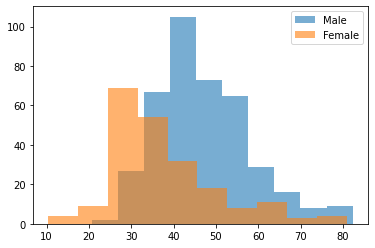

In [ ]:
plt.hist(df[df["genderLabel"]=="male"]["Age_while_awarded"].reset_index(drop=True), alpha=0.6, label="Male")
plt.hist(df[df["genderLabel"]=="female"]["Age_while_awarded"].reset_index(drop=True), alpha=0.6, label="Female")
plt.legend()
plt.show()